In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch

In [2]:
# Check if GPU is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
n = 30

In [4]:
X = np.vstack([np.load(f"Datasets/kryptonite-{n}-X.npy"), np.load(f"Datasets/additional-kryptonite-{n}-X.npy")])
y = np.concatenate([np.load(f"Datasets/kryptonite-{n}-y.npy"), np.load(f"Datasets/additional-kryptonite-{n}-y.npy")])
X.shape
y.shape

(310000,)

In [5]:
# Remove ambiguous rows
am = 0.2
non_am_rows = (((X > 0.5-am) & (X < 0.5+am)).sum(axis=1) == 0)
X_nam = X[non_am_rows]
y_nam = y[non_am_rows]

def round_to_binary_numpy(values):
    """
    Rounds each value in the input NumPy array to 0 or 1 based on closeness.
    """
    values = np.array(values)  # Ensure input is a NumPy array
    return (values >= 0.5).astype(int)

X_mod = round_to_binary_numpy(X_nam)

X_final = X_mod
y_final = y_nam

print(X_final.shape, y_final.shape)
print(X_final)

(302019, 30) (302019,)
[[1 1 1 ... 1 0 0]
 [1 1 0 ... 1 1 0]
 [0 1 1 ... 0 0 0]
 ...
 [0 0 1 ... 0 1 0]
 [1 0 0 ... 1 1 1]
 [1 0 1 ... 1 1 0]]


In [6]:
# Shuffle and split the data
X_train, X_temp, y_train, y_temp = train_test_split(X_final, y_final, test_size=0.4, random_state=42)  # 60% training
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # 20% validation, 20% test
print(X_train.shape, X_val.shape, X_test.shape)

(181211, 30) (60404, 30) (60404, 30)


In [7]:
class NeuralNetwork(torch.nn.Module):
    def __init__(self, layer_sizes, dropout_rate=0.5):
        super(NeuralNetwork, self).__init__()

        # Create layers based on layer_sizes
        layers = []
        for i in range(len(layer_sizes) - 1):
            layers.append(torch.nn.Linear(layer_sizes[i], layer_sizes[i + 1]))

            # Add activation function and dropout except for the last layer
            if i < len(layer_sizes) - 2:
                layers.append(torch.nn.ReLU())
                #layers.append(torch.nn.Dropout(dropout_rate))  # Add dropout with specified rate

        # Use nn.Sequential to stack the layers
        self.model = torch.nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [8]:
device

device(type='cuda')

In [9]:
seed = 160
torch.manual_seed(seed)

layer_sizes = [n, 128, 16, 2] # best setting for n = 24

layer_sizes = [n, 256, 256, 32, 2] # best setting for n = 30

net = NeuralNetwork(layer_sizes, dropout_rate=0.2).to(device)

# Define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(net.parameters(), amsgrad=True, weight_decay=0.12)

def count_parameters(model):
    """
    Counts the total number of trainable parameters in a PyTorch model.
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(count_parameters(net))
print(X_train.shape)

82018
(181211, 30)


In [10]:
# Convert input data to PyTorch tensors and move to GPU
X_train_tensor = torch.from_numpy(X_train).float().to(device)
y_train_tensor = torch.from_numpy(y_train).long().to(device)
X_val_tensor = torch.from_numpy(X_val).float().to(device)
y_val_tensor = torch.from_numpy(y_val).long().to(device)

In [11]:
# Training parameters
num_epochs = 5000
print_interval = 100

# Lists to store metrics for plotting
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

best_val_loss = 1
best_model_state = None

for epoch in range(num_epochs):
    # Training mode
    net.train()

    optimizer.zero_grad()

    # Forward pass on training data
    output_train = net(X_train_tensor)
    train_loss = criterion(output_train, y_train_tensor)

    # Backward pass and optimization
    train_loss.backward()
    optimizer.step()

    if (epoch + 1) % print_interval == 0:
        # Validation mode
        net.eval()
        with torch.no_grad():  # No gradient calculation during validation
            output_train = net(X_train_tensor)
            _, predicted_train = torch.max(output_train, 1)
            train_accuracy = (predicted_train == y_train_tensor).float().mean().item()

            output_val = net(X_val_tensor)
            val_loss = criterion(output_val, y_val_tensor)

            # Calculate validation accuracy
            _, predicted_val = torch.max(output_val, 1)
            val_accuracy = (predicted_val == y_val_tensor).float().mean().item()

        print(f"Epoch [{epoch + 1}/{num_epochs}]")
        print(f"Train Loss: {train_loss.item():.4f}, Train Accuracy: {train_accuracy * 100:.2f}%")
        print(f"Val Loss: {val_loss.item():.4f}, Val Accuracy: {val_accuracy * 100:.2f}%\n")

        # store all values for plotting
        train_losses.append(train_loss.item())
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss.item())
        val_accuracies.append(val_accuracy)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = net.state_dict()

print(f"Best val loss: {best_val_loss}")            
#  restore model with best val loss
net.load_state_dict(best_model_state)

Epoch [100/5000]
Train Loss: 0.6777, Train Accuracy: 57.28%
Val Loss: 0.7011, Val Accuracy: 50.02%

Epoch [200/5000]
Train Loss: 0.6534, Train Accuracy: 61.68%
Val Loss: 0.7154, Val Accuracy: 50.39%

Epoch [300/5000]
Train Loss: 0.6343, Train Accuracy: 64.34%
Val Loss: 0.7264, Val Accuracy: 50.93%

Epoch [400/5000]
Train Loss: 0.6204, Train Accuracy: 65.70%
Val Loss: 0.7378, Val Accuracy: 51.16%

Epoch [500/5000]
Train Loss: 0.6059, Train Accuracy: 67.16%
Val Loss: 0.7470, Val Accuracy: 51.21%

Epoch [600/5000]
Train Loss: 0.5943, Train Accuracy: 68.24%
Val Loss: 0.7523, Val Accuracy: 51.70%

Epoch [700/5000]
Train Loss: 0.5883, Train Accuracy: 68.60%
Val Loss: 0.7621, Val Accuracy: 51.93%

Epoch [800/5000]
Train Loss: 0.5715, Train Accuracy: 70.47%
Val Loss: 0.7566, Val Accuracy: 52.73%

Epoch [900/5000]
Train Loss: 0.5558, Train Accuracy: 71.66%
Val Loss: 0.7524, Val Accuracy: 53.71%

Epoch [1000/5000]
Train Loss: 0.5405, Train Accuracy: 72.82%
Val Loss: 0.7443, Val Accuracy: 54.89%


<All keys matched successfully>

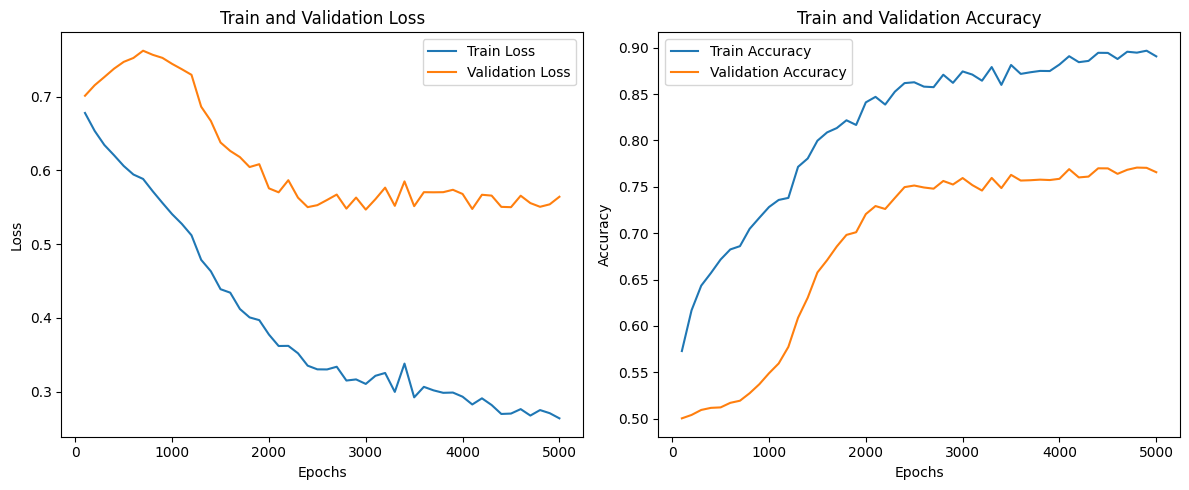

In [12]:
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 5))

# Plot Train and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(epochs[print_interval - 1::print_interval][:len(train_losses)], train_losses, label="Train Loss")
plt.plot(epochs[print_interval - 1::print_interval][:len(val_losses)], val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Loss")
plt.legend()

# Plot Train and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs[print_interval - 1::print_interval][:len(train_accuracies)], train_accuracies, label="Train Accuracy")
plt.plot(epochs[print_interval - 1::print_interval][:len(val_accuracies)], val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [13]:
# check test accuracy
X_test_tensor = torch.from_numpy(X_test).float().to(device)
y_test_tensor = torch.from_numpy(y_test).long().to(device)

net.eval()
with torch.no_grad():  # No gradient calculation during validation
    output_test = net(X_test_tensor)
    _, predicted_test = torch.max(output_test, 1)
    test_accuracy = (predicted_test == y_test_tensor).float().mean().item()
    print(f"Test Accuracy: {test_accuracy * 100:.2f}%\n")

Test Accuracy: 76.46%

